# Analiza pasemskih mačk

In [204]:
import pandas as pd
import os.path
import re
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.options.display.max_rows = 10
#%matplotlib notebook
%matplotlib inline

# naložimo razpredelnico, s katero bomo delali
pot_do_drzav = os.path.join("drzave.csv")
drzave = pd.read_csv(pot_do_drzav)

### Obdelava podatkov

Tabeli dodamo stolpec 'gostota prebivalstva' in odstranimo stolpce, ki jih ne bomo potrebovali.

In [205]:
drzave['gostota prebivalstva'] = drzave['prebivalstvo']/drzave['povrsina [km^2]']
drzave = drzave.iloc[:, [0, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15]]
drzave

,drzava,povprecna starost,starost moski,starost zenske,% prekomero tezkih,indeks izobrazbe 2015,procent uporabnikov interneta,poraba energije [vat],st restavracij na 100k ljudi,bdp 2020,gostota prebivalstva
0,Afghanistan,19.5,19.4,19.5,5.5,0.398,11.45,18.0,NaN,499.0,59.627403
1,Albania,34.3,32.9,35.7,21.7,0.715,71.85,194.0,NaN,4898.0,105.029088
2,Algeria,28.9,28.6,29.3,27.4,0.658,47.69,164.0,NaN,3331.0,18.411348
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,NaN,NaN
4,Andorra,46.2,46.3,46.1,25.6,0.718,98.87,739.0,6.4,NaN,164.393617
...,...,...,...,...,...,...,...,...,...,...,...
240,West Bank,NaN,NaN,NaN,NaN,NaN,NaN,126.0,NaN,NaN,NaN
241,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2894.0,NaN
242,Yemen,19.8,19.6,19.9,17.1,0.350,26.72,10.0,NaN,645.0,56.491778
243,Zambia,16.9,16.7,17.0,8.1,0.577,27.85,84.0,NaN,1001.0,24.729893


<AxesSubplot:title={'center':'15 držav z najvišjo povprečno starostjo in 15 z najnižjo'}, xlabel='drzava'>

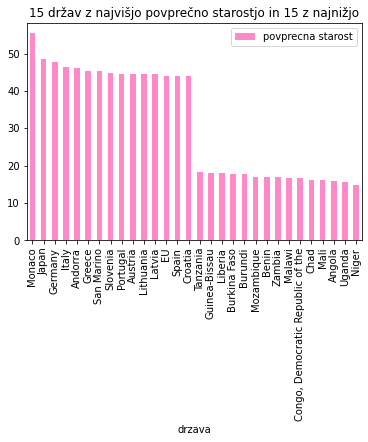

In [97]:
d_top = drzave.sort_values('povprecna starost', ascending=False).head(15)
d_bot = drzave.sort_values('povprecna starost', ascending=True).head(15).sort_values(by = 'povprecna starost', ascending=False)
pd.concat([d_top, d_bot]).plot.bar(x='drzava', y='povprecna starost', color = 'deeppink', alpha = 0.5, title = '15 držav z najvišjo povprečno starostjo in 15 z najnižjo')

#### Višji izobrazbeni indeks, več interneta

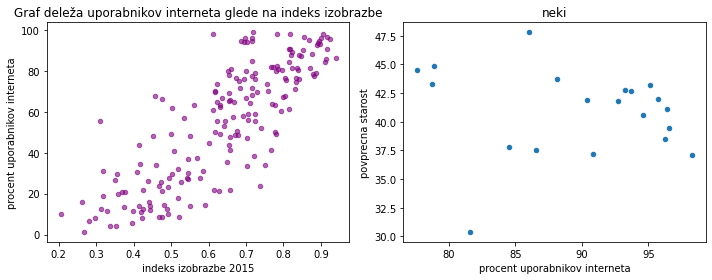

In [196]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
drzave.plot.scatter('indeks izobrazbe 2015', 'procent uporabnikov interneta', alpha = 0.6, c = 'purple', title = 'Graf deleža uporabnikov interneta glede na indeks izobrazbe', ax=ax1)


drzave[drzave['indeks izobrazbe 2015'] > 0.85].plot.scatter('procent uporabnikov interneta', 'povprecna starost', title = 'neki',ax=ax2)
plt.tight_layout()

#### Višji BDP, višja izobrazba

<AxesSubplot:title={'center':'BDP pp glede na indeks izobrazbe'}, xlabel='indeks izobrazbe 2015', ylabel='bdp 2020'>

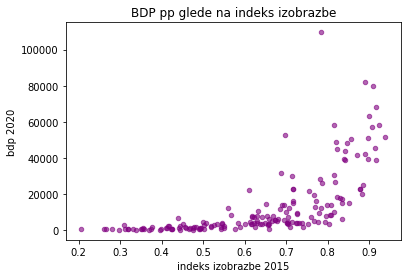

In [99]:
drzave.plot.scatter('indeks izobrazbe 2015', 'bdp 2020', alpha = 0.6, c = 'purple', title = 'BDP pp glede na indeks izobrazbe')
#regresija

#### Več težkih, višji BDP

<AxesSubplot:title={'center':'Več težkih, višji BDP'}, xlabel='% prekomero tezkih', ylabel='bdp 2020'>

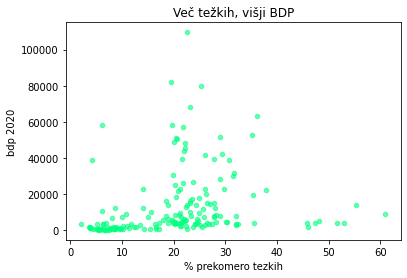

In [100]:
drzave.plot.scatter('% prekomero tezkih', 'bdp 2020', alpha = 0.6, c = 'springgreen', title = 'Več težkih, višji BDP')


#### Starostna struktura, mcdonalds

,drzava,st restavracij na 100k ljudi,povprecna starost
83,Gibraltar,49.6,NaN
4,Andorra,6.4,46.2
144,Monaco,5.2,55.4
233,United States,4.3,38.5
38,Canada,3.9,41.8


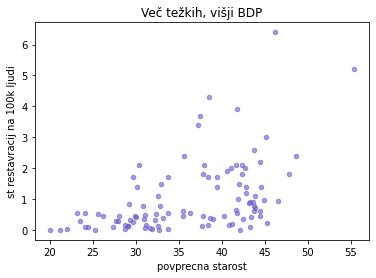

In [148]:
drzave.plot.scatter('povprecna starost', 'st restavracij na 100k ljudi', alpha = 0.6, c = 'slateblue', title = 'Več težkih, višji BDP')
df = drzave.sort_values('st restavracij na 100k ljudi', ascending=False).head(5)
df[['drzava', 'st restavracij na 100k ljudi', 'povprecna starost']]

#### Vnos kalorij, več težkih

Text(0.5, 1.0, 'Povprečni vnos kalorij glede na delež prekomerno težkih')

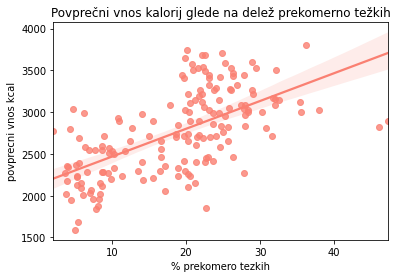

In [147]:
sns.regplot(x="% prekomero tezkih", y="povprecni vnos kcal", data=drzave, color = 'salmon').set_title('Povprečni vnos kalorij glede na delež prekomerno težkih')

#### Višja gostota, večji BDP

<AxesSubplot:title={'center':'Višja gostota, večji BDP'}, xlabel='gostota prebivalstva', ylabel='bdp 2020'>

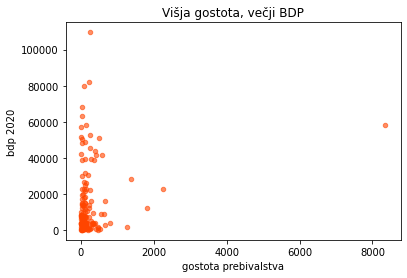

In [177]:
drzave.plot.scatter('gostota prebivalstva', 'bdp 2020', alpha = 0.6, c = 'orangered', title = 'Višja gostota, večji BDP')

In [178]:
drzave['indeks izobrazbe 2015']

0      0.398
1      0.715
2      0.658
3        NaN
4      0.718
       ...  
240      NaN
241      NaN
242    0.350
243    0.577
244    0.544
Name: indeks izobrazbe 2015, Length: 245, dtype: float64

#### Zemljevidi

In [198]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim